In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [2]:
def iou(input, targs, iou=True, eps=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [3]:
### Script begins here ###

path = '../Dataset'
path_lbl = os.path.join(path, 'groundtruths')

In [4]:
fnames_lbl=get_image_files(path_lbl)
print(path_lbl)

../Dataset/groundtruths


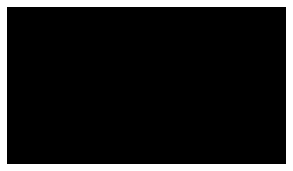

In [5]:
img_f = fnames_lbl[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: os.path.join(path_lbl, f'{x.stem}_groundtruth.png')

In [7]:
(SegmentationItemList)

fastai.vision.data.SegmentationItemList

In [8]:
# Classes (i.e. the possible values in the mask .png)
codes = ['0', '1']

src = (SegmentationItemList.from_folder(path=path)
      .split_by_folder(train='train', valid='valid')
      .label_from_func((get_y_fn), classes=codes))

ds_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180., max_zoom=1.1,
                   max_lighting=0.13, max_warp=0, p_affine=0.75,
                   p_lighting=0.75)

In [10]:
size = (224,224)
bs = 32
data = (src.transform(ds_tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

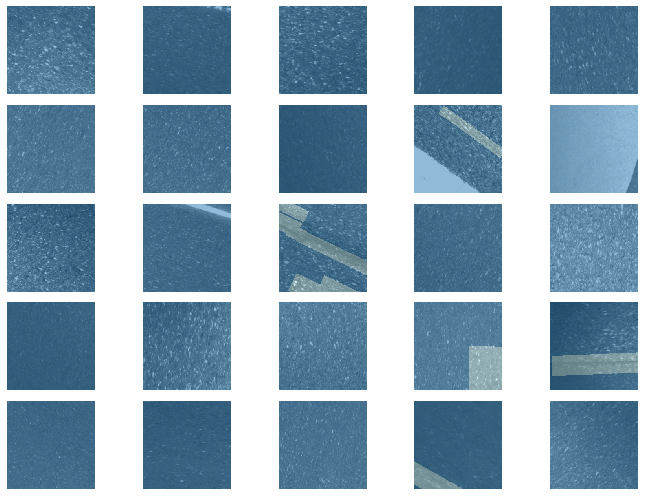

In [11]:
data.show_batch(5,figsize=(10,7))

In [ ]:
doc(unet_learner)

In [12]:
learn = unet_learner(data, models.resnet34, metrics=[dice, iou], wd=1e-2)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(3e-4))

In [ ]:
learn.save('model-4 .1')
learn.export('model-4.1')

In [ ]:
print(learn.summary())

In [ ]:
learn = load_learner(path,'model-3.1')
learn.data = data
learn.summary()

In [ ]:
learn.show_results(rows=10, figsize=(50,50))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=iou, wd=1e-2)
lr_find(learn)
learn.recorder.plot()

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

epoch,train_loss,valid_loss,dice,iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


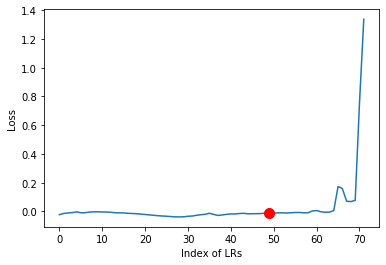

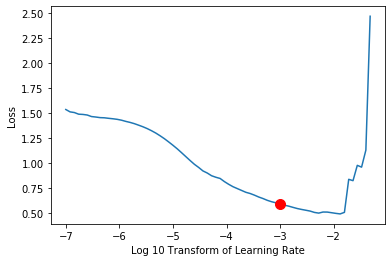

In [12]:
learn = unet_learner(data, models.resnet34, metrics=[dice, iou], wd=1e-2)
lr = find_appropriate_lr(learn)

In [13]:
print(lr)

0.001


In [14]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(lr))

epoch,train_loss,valid_loss,dice,iou,time
0,0.104613,0.132836,0.738222,0.738222,1:14:24
1,0.090142,0.144154,0.738635,0.738549,1:12:19
2,0.090329,0.187301,0.741969,0.741478,1:11:51
3,0.081715,0.140690,0.735491,0.734250,1:11:49
4,0.083030,0.131658,0.768843,1.653438,1:11:51
5,0.071186,0.144785,0.761527,1.257922,1:11:52
6,0.073074,0.136183,0.775900,1.871533,1:11:56
7,0.071104,0.131540,0.778913,1.856097,1:11:57


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



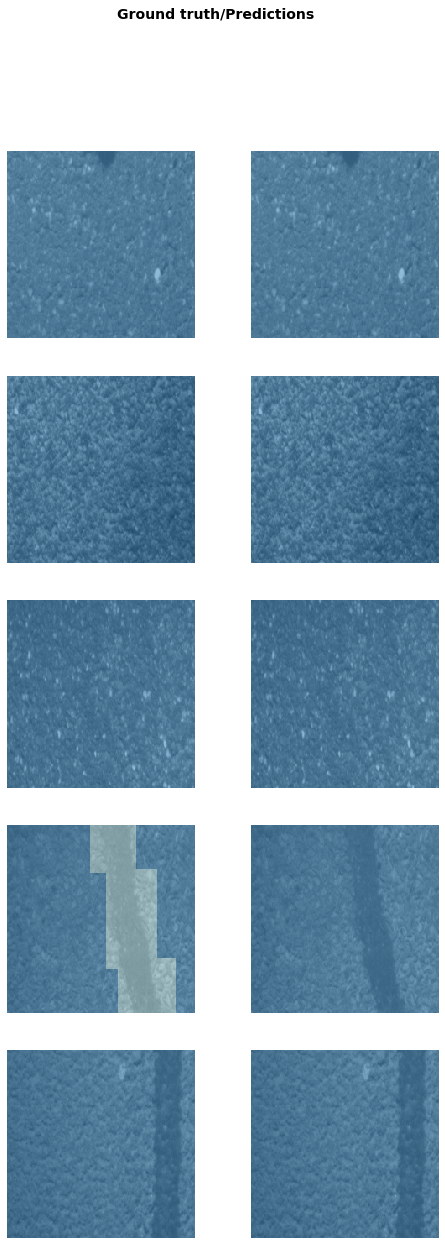

In [19]:
learn.show_results()

In [17]:
learn.save('model-5.1')
learn.export('model-5.1')

In [ ]:
from fastai.vision import interpret 

In [ ]:
interp = interpret.SegmentationInterpretation.from_learner(learn)

In [ ]:
#Testing
img = open_image("../Dataset/valid0/_cam12_1480601821463_002038_seg11.png")
#for i in range(145,180):
img = data.train_ds[16001][0]
img.show()
prediction = learn.predict(img)[0]
#img.show(y=learn.predict(img)[0])
img.show(y=prediction)
#print(prediction[0])


In [ ]:
import statistics 
sum=0
print(prediction.data)

print(sum)

In [ ]:
print(data.train_ds)

In [ ]:
learn.data.classes

In [ ]:
data.train_ds??

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
interp.show_xyz(i, sz=15)

In [ ]:
len(data.valid_ds) 

In [ ]:
len(data.train_ds)

In [23]:
doc(learn.show_results)

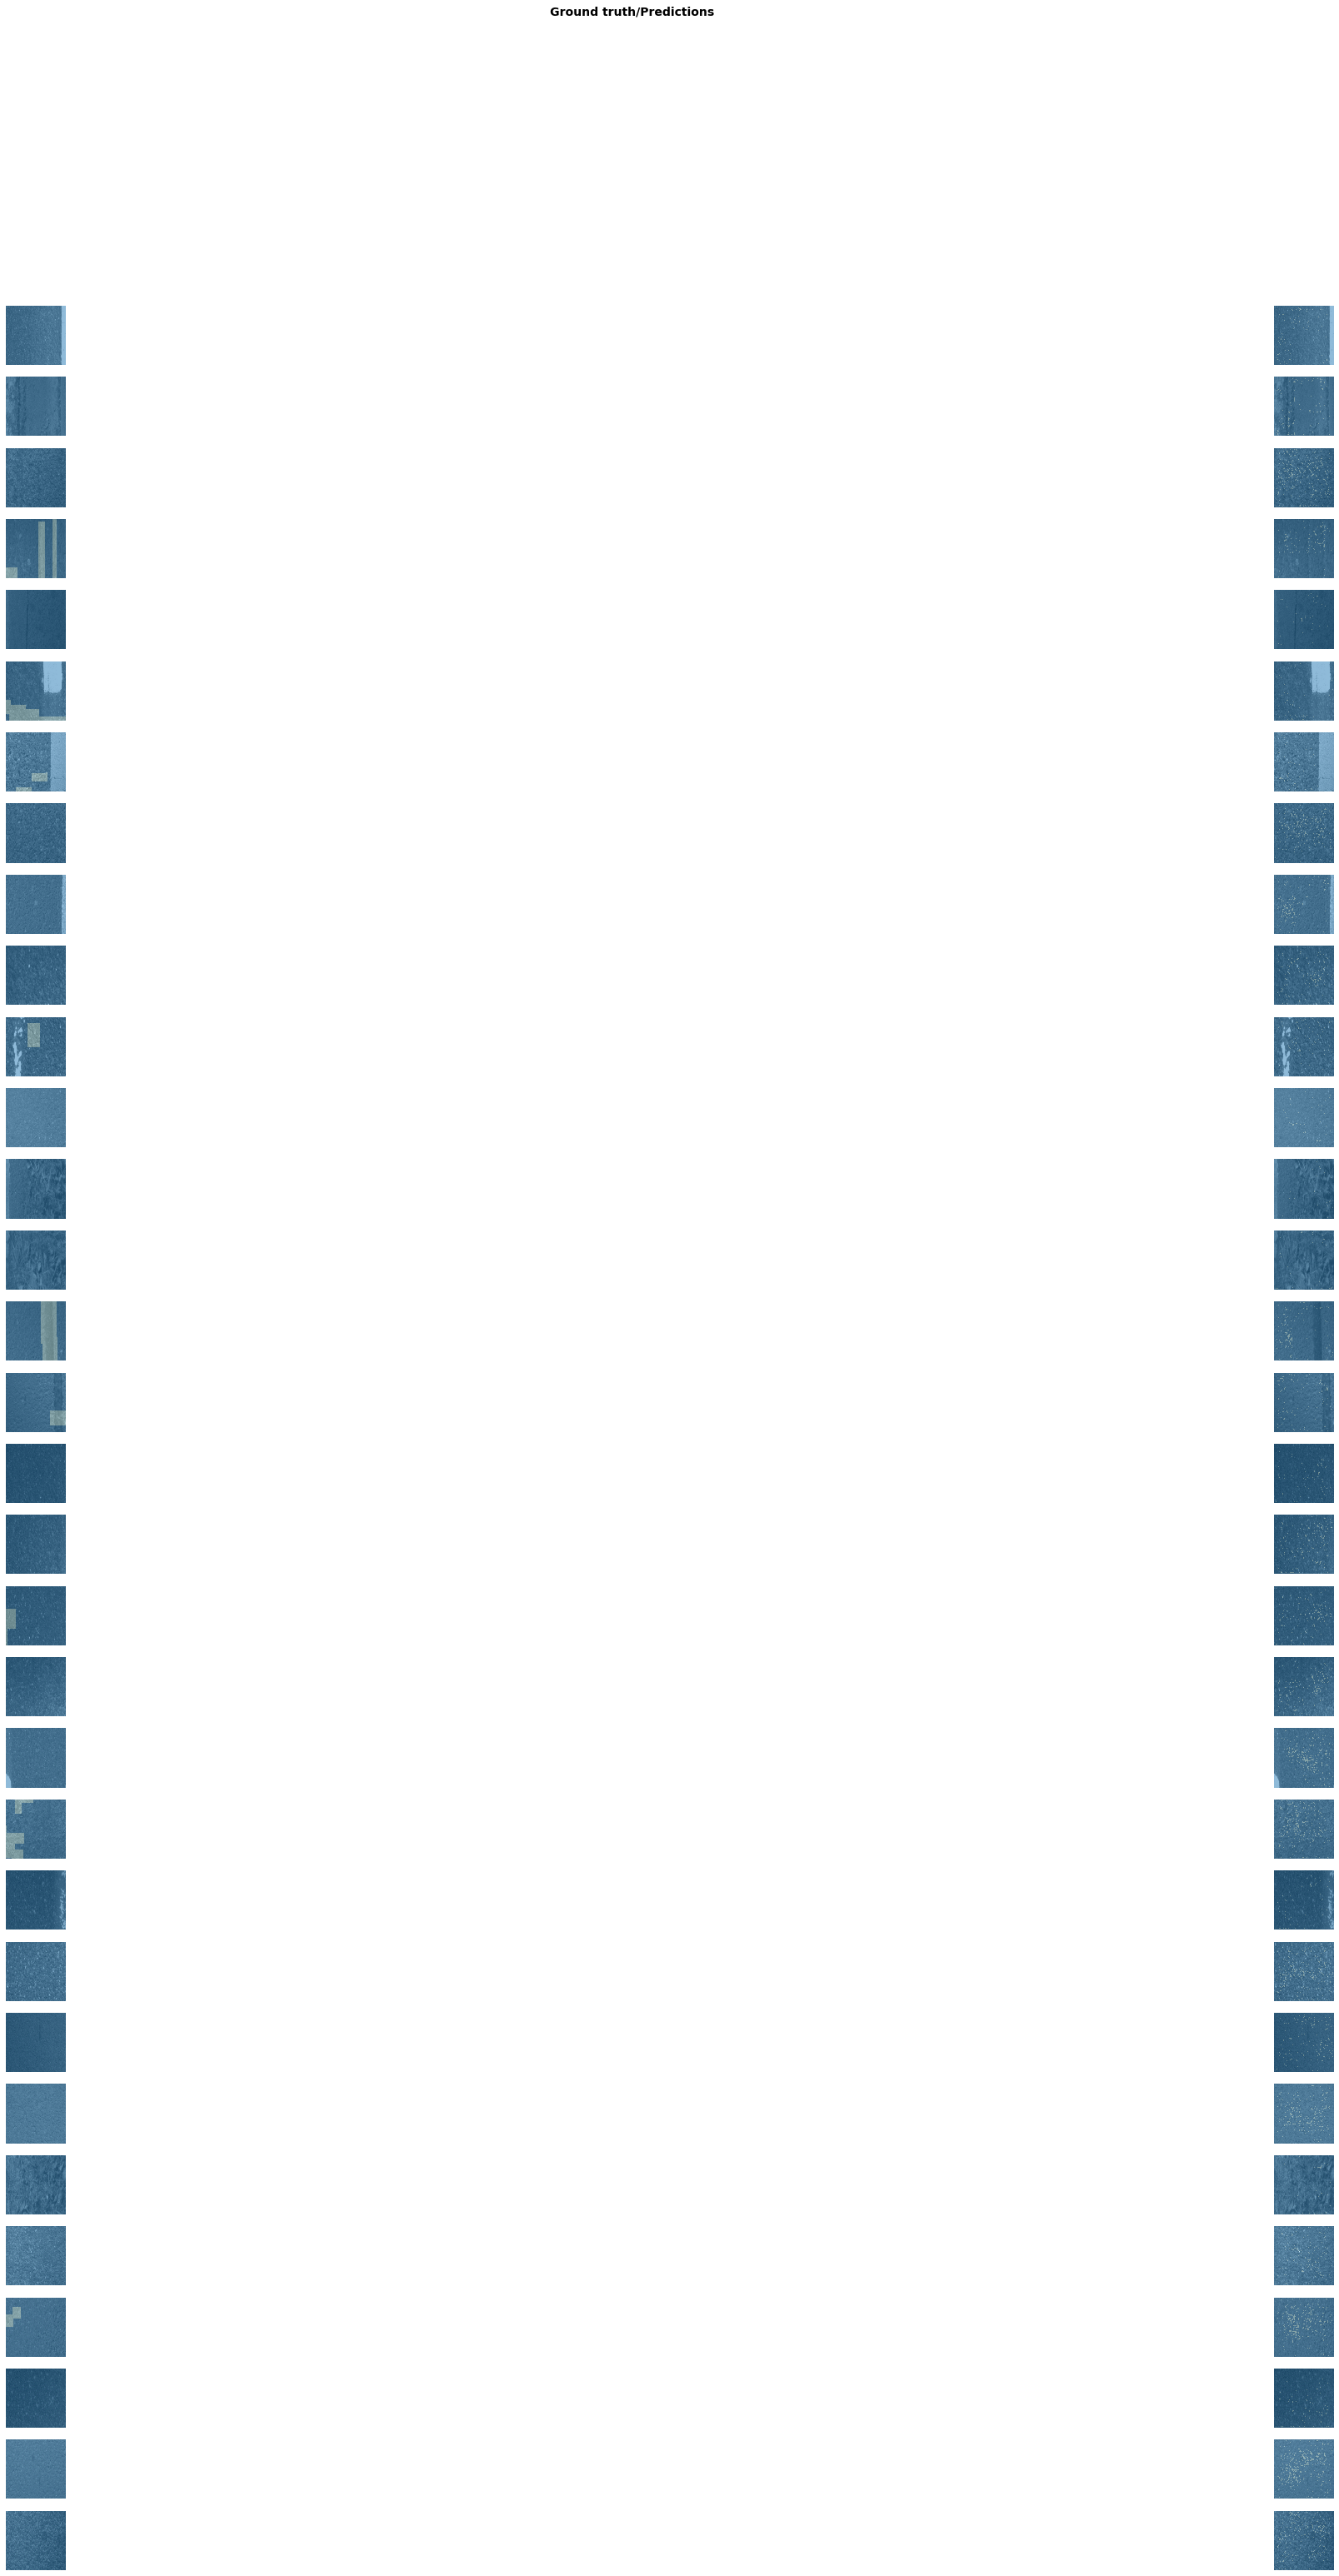

In [19]:
data.valid_dl = data.valid_dl.new(shuffle=True)
learn.show_results(rows=100, figsize=(50,50), ds_type=DatasetType.Valid, alpha=0.5)
data.valid_dl = data.valid_dl.new(shuffle=False)